In [37]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul  8 08:06:29 2019

@author: wrush049
"""
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


In [38]:
def calc_current_var(series, current_price, percentile, nsims=1e6):
        
    nsims = int(nsims)
    mean_returns = np.mean(series)
    std = np.std(series)
    
    Z = stats.norm.ppf(1 - percentile/100)
    
    # Calculate parametric VAR
    param_var = current_price*Z*std

    
    # Calculate historical VaR
    hist_var = current_price*np.percentile(series, 100 - percentile)
    
    # Monte-Carlo simulation of VaR
    sim_returns = np.random.normal(mean_returns, std, nsims)
    sim_var = current_price*np.percentile(sim_returns, 100 - percentile)
    return (param_var, hist_var, sim_var)


In [39]:
# Get and format the data
filepath = "C:/Users/wrush049/Desktop/Tulsa RVP Giveaway/Historical Butane, Crude, Gas Prices.xlsx"
df = pd.read_excel(open(filepath, 'rb'))
new_header = df.iloc[0] #grab the first row for the header
df = df[2:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df = df.reset_index(drop=True)

In [40]:
# calculate VaR for Butane
df["Butane Returns"] = df["Conway In-Well Normal Butane [BBL]"].pct_change()
# This is the same as (df["Butane [BBL]"]/df["Butane [BBL]"].shift(1))-1

# Price on the spreadsheet is given in cents per BBL, this moves it to $
current_price = df["Conway In-Well Normal Butane [BBL]"].dropna().iloc[-1]/100

series = df["Butane Returns"].dropna().iloc[-365:].reset_index(drop=True)

for percent in [90, 95, 99]:
    param, hist, sim = calc_current_var(series, current_price, percent)
    print(f"ParamVaR{percent}: {param:0.2f}, HistVaR{percent}: {hist:0.2f}, SimVaR{percent}: {sim:0.2f}")

ParamVaR90: -0.65, HistVaR90: -0.64, SimVaR90: -0.68
ParamVaR95: -0.83, HistVaR95: -0.88, SimVaR95: -0.87
ParamVaR99: -1.18, HistVaR99: -1.49, SimVaR99: -1.22


# Moving onto an ARIMA test

In [41]:
# Testing is our series is stationary using automated dickey fuller test (ADF)
result = adfuller(df["Butane Returns"].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Because I'm using returns with a constant mean instead of price itself which has a moving mean
# and a lognormal distribution my p-value is below significance so I can skip the next cell

ADF Statistic: -17.896982521689974
p-value: 2.9631092402836327e-30


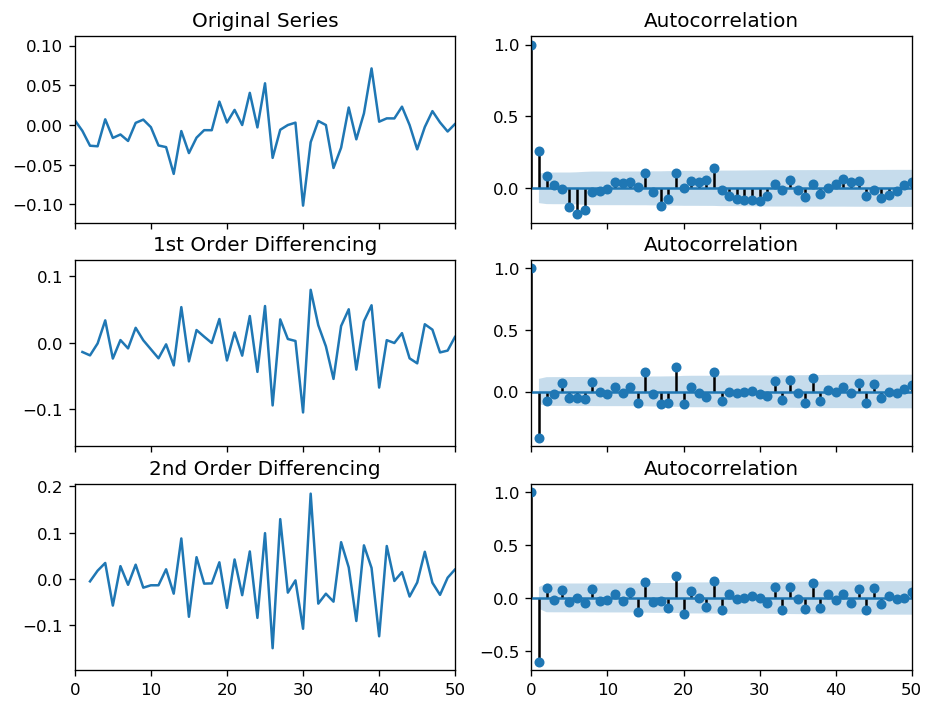

In [42]:
# Example of what to do is the ADF p-value is above significance


fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
axes[0, 0].set(xlim=(0, 50))
plot_acf(series, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(series.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

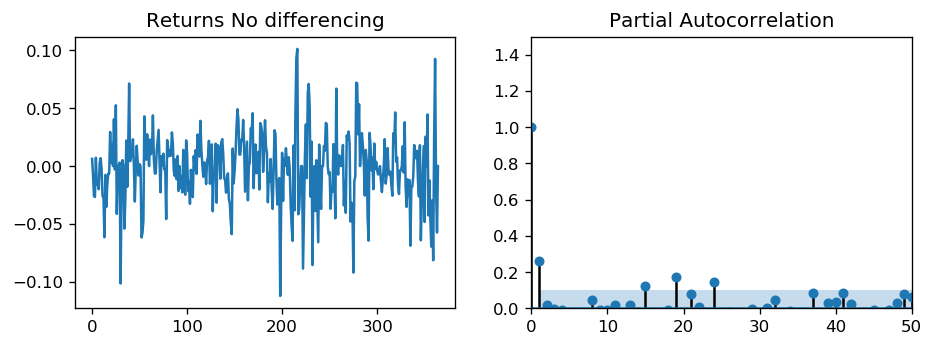

In [43]:
# PACF plot of series with the differencing found in cell above
# This is to find the p term
# NOTE: This cell will take a while to run after throwing the error
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(series); axes[0].set_title('Returns No differencing')
axes[1].set(ylim=(0,1.5))
axes[1].set(xlim=(0, 50))

plot_pacf(series, ax=axes[1])

plt.show()
# Looking at the plot, there seems to be a significance at 1 (of course it is not 1, the signficance of 0 lag)
#The significance seems to be above the blue significance boundary

In [44]:
# Now that you've visualized the results lets check with numbers
pacf_vals = pacf(series, nlags=50, method='yw', alpha=None)
print(pacf_vals[0:5])

# as you can see, the value at lag 1 is above the signifcance limit of the pacf

[ 1.          0.26380314  0.01582697 -0.00168814 -0.00996902]


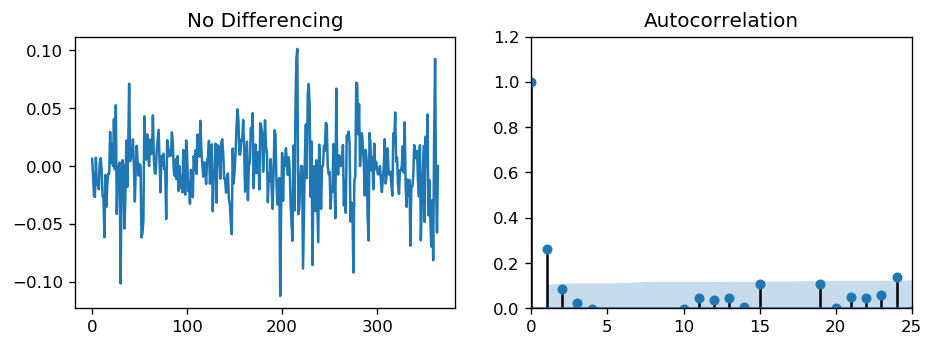

In [45]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2)
axes[0].plot(series); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set(xlim=(0, 25))
plot_acf(series, ax=axes[1])
plt.show()

# We are looking to see what lags are above the signficicance line
# Removing them with this term is important but you do not want to make the model more complex than necessary
# In this case, our lag we want to remove is 1, so our q=1

In [46]:
# Time to build the ARIMA model

# p (autoregressive) = 1 b/c pacf 1 greater than signficance bounds
# d (differencing) = 0 bc series is stationary
# q (moving average) = 1 b/c acf 1 is the only lag greater than significance
model = ARIMA(series, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Advice
#It may so happen that your series is slightly under differenced,
#that differencing it one more time makes it slightly over-differenced.
#How to handle this case?
#If your series is slightly under differenced, adding one or more additional AR terms usually makes it up.
#Likewise, if it is slightly over-differenced, try adding an additional MA term.

                              ARMA Model Results                              
Dep. Variable:         Butane Returns   No. Observations:                  365
Model:                     ARMA(1, 0)   Log Likelihood                 781.980
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 09 Jul 2019   AIC                          -1557.960
Time:                        09:40:20   BIC                          -1546.260
Sample:                             0   HQIC                         -1553.310
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0020      0.002     -1.002      0.317      -0.006       0.002
ar.L1.Butane Returns     0.2624      0.050      5.204      0.000       0.164       0.361
            

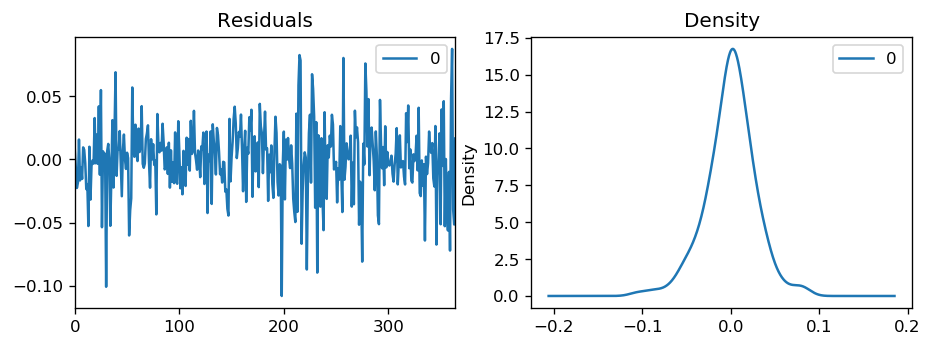

In [47]:
# Plot the residuals to see if there is systematic error
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# For our data, the resisudals mean is near 0 and a near normal distribution
# This is good

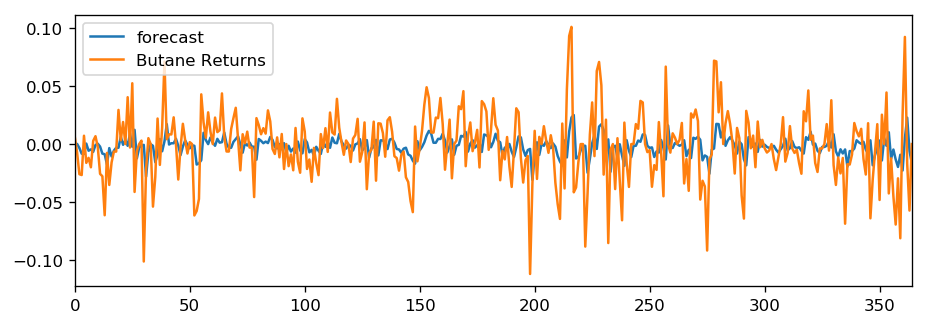

In [48]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [49]:
# Create Training and Test
# Create independent series 
overall_set = df["Butane Returns"].dropna()[-365:].reset_index(drop=True)
train = overall_set[:230]
test = overall_set[230:]

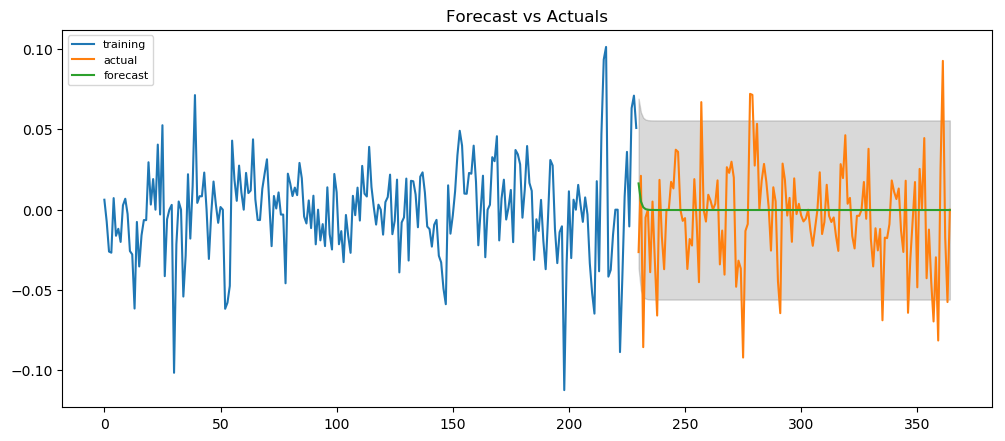

In [50]:

# Build model
model = ARIMA(train, order=(1, 0, 0))
fitted = model.fit(disp=-1)

# forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05) # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [55]:
import pmdarima as pm
model = pm.auto_arima(overall_set, start_p=1, start_q=1,
                      test='adf', # use adfuller test to find optimal 
                      max_p=3, max_q=3, # set max reasonable vals
                      m=1, # frequency of series
                      d=None, # allow model to vary d
                      seasonal=False, # nonseasonal data
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1); AIC=-1556.047, BIC=-1540.447, Fit time=0.156 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-1533.846, BIC=-1526.046, Fit time=0.000 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-1557.960, BIC=-1546.260, Fit time=0.031 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-1555.631, BIC=-1543.931, Fit time=0.031 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-1556.049, BIC=-1540.449, Fit time=0.047 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-1557.019, BIC=-1537.520, Fit time=0.469 seconds
Total fit time: 0.734 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(1, 0)   Log Likelihood                 781.980
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 09 Jul 2019   AIC                          -1557.960
Time:                        09:41:41   BIC                          -1546.260
Sample:   

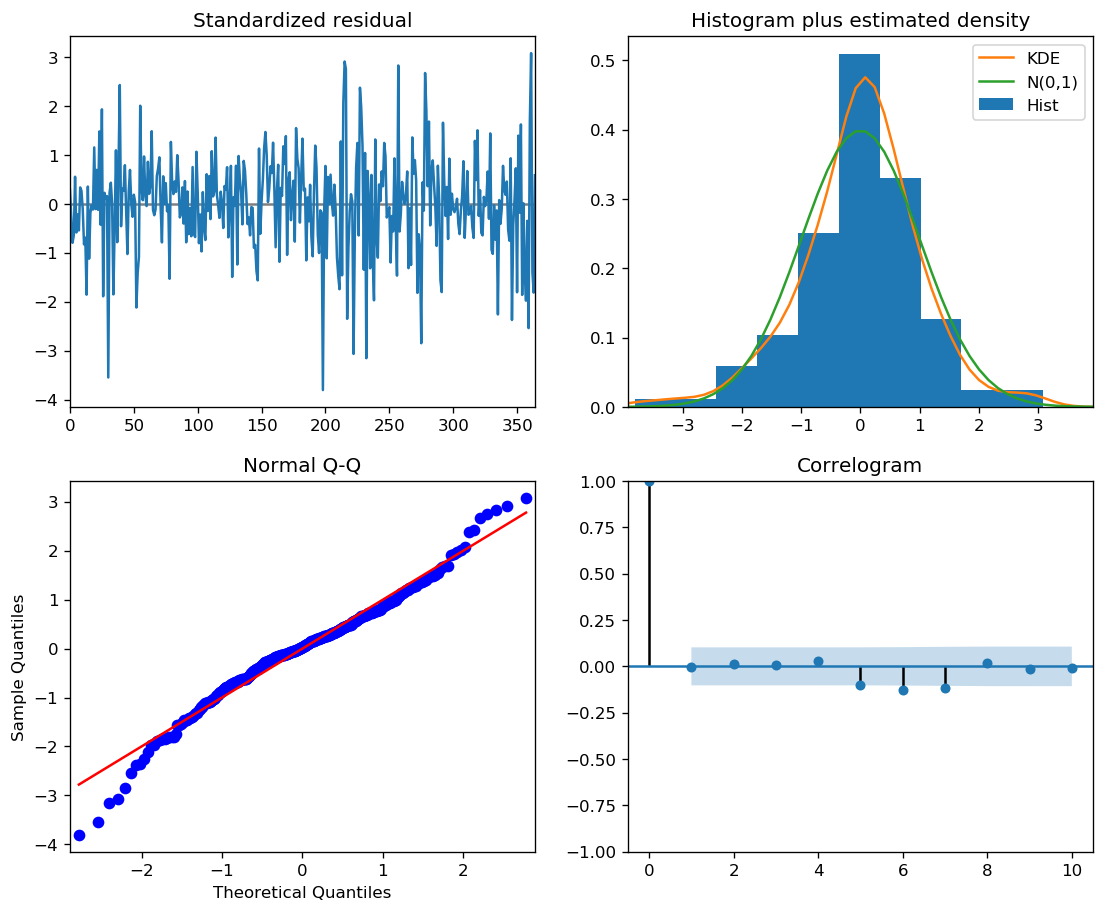

In [56]:
model.plot_diagnostics(figsize=(11,9))
plt.show()

# What does this show?
# Top left: Residual errors seem to fluctuate around a mean of 0 with no real pattern
# Top right: Roughly normal distribution with a mean around 0
# Bot left: All points ideally would fall on the red line. Any significant deviations are noted here
# Bot right: ACF plot shows that the erros are not autocorrelated. If there is significant autocorrrelation
#            another variable might need to be found to explain this

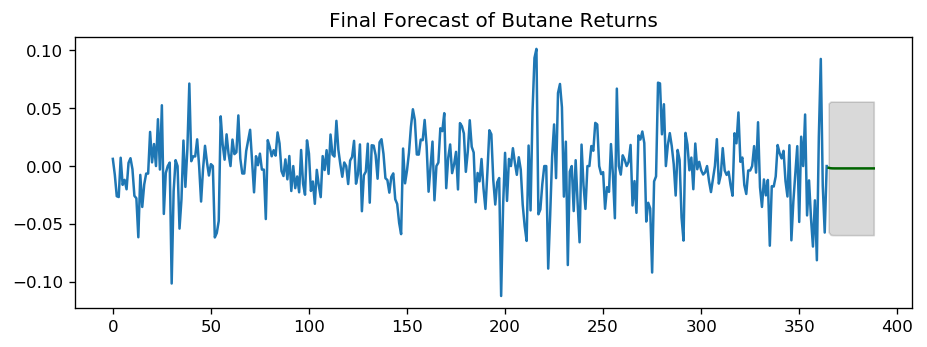

In [57]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(overall_set), len(overall_set)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(overall_set)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Butane Returns")
plt.show()

# Trying it with raw butane prices

In [75]:
data = df["Conway In-Well Normal Butane [BBL]"].dropna().reset_index(drop=True)/100

model = pm.auto_arima(data, start_p=1, start_q=1,
                      test='adf', # use adfuller test to find optimal 
                      max_p=3, max_q=3, # set max reasonable vals
                      m=1, # frequency of series
                      d=None, # allow model to vary d
                      seasonal=False, # nonseasonal data
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=3763.228, BIC=3784.315, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 0); AIC=3891.932, BIC=3902.475, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0); AIC=3770.546, BIC=3786.361, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 1); AIC=3763.238, BIC=3779.053, Fit time=0.031 seconds
Fit ARIMA: order=(2, 1, 1); AIC=3755.946, BIC=3782.305, Fit time=0.109 seconds
Fit ARIMA: order=(2, 1, 0); AIC=3757.608, BIC=3778.695, Fit time=0.031 seconds
Fit ARIMA: order=(2, 1, 2); AIC=3752.286, BIC=3783.916, Fit time=0.277 seconds
Fit ARIMA: order=(3, 1, 3); AIC=3755.563, BIC=3797.737, Fit time=1.367 seconds
Fit ARIMA: order=(1, 1, 2); AIC=3757.425, BIC=3783.784, Fit time=0.187 seconds
Fit ARIMA: order=(3, 1, 2); AIC=3753.243, BIC=3790.145, Fit time=0.288 seconds
Fit ARIMA: order=(2, 1, 3); AIC=3753.091, BIC=3789.993, Fit time=0.310 seconds
Total fit time: 2.757 seconds
                             ARIMA Model Results                              
Dep. Variable:        

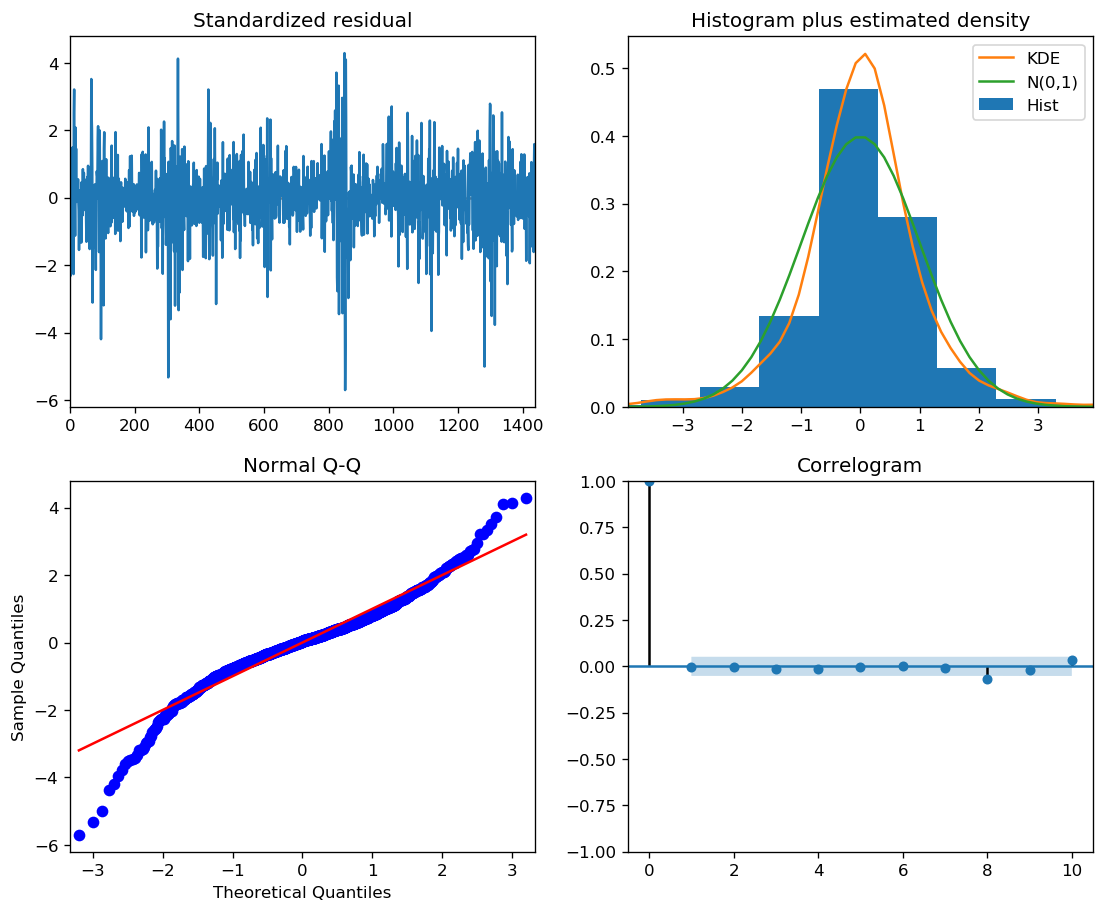

In [76]:
model.plot_diagnostics(figsize=(11,9))
plt.show()

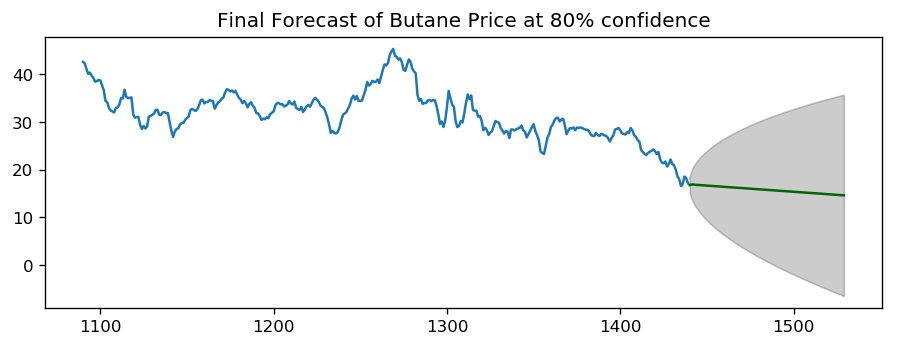

In [81]:
# Forecast
n_periods = 90
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data), len(data)+n_periods)


# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
window = 350
plt.plot(data.index[-window:], data[-window:])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.20)
plt.title("Final Forecast of Butane Price at 80% confidence")
plt.show()